In [3]:
import pandas as pd

file_path = '/Users/ulrika/Desktop/presidential_executive_orders.csv'
data = pd.read_csv(file_path)

data.head()

,signing_date,title,president,topics,executive_order_notes,citation,agency_names,significant,body_html_url,text
0,2024-09-11,Investing in America and Investing in American...,Joseph R. Biden Jr.,[],NaN,89 FR 73559,['Executive Office of the President'],NaN,https://www.federalregister.gov/documents/full...,"Executive Order 14126 of September 6, 2024\nIn..."
1,2024-07-24,Establishing an Emergency Board To Investigate...,Joseph R. Biden Jr.,[],NaN,89 FR 60791,['Executive Office of the President'],NaN,https://www.federalregister.gov/documents/full...,"Executive Order 14125 of July 24, 2024\nEstabl..."
2,2024-07-17,White House Initiative on Advancing Educationa...,Joseph R. Biden Jr.,[],"See: EO 14045, September 13, 2021",89 FR 59585,['Executive Office of the President'],NaN,https://www.federalregister.gov/documents/full...,"Executive Order 14123 of June 14, 2024\nWhite ..."
3,2024-06-14,White House Council on Supply Chain Resilience,Joseph R. Biden Jr.,[],"See: EO 14017, February 24, 2021\r\nSupersedes...",89 FR 51949,['Executive Office of the President'],NaN,https://www.federalregister.gov/documents/full...,"Executive Order 14123 of June 14, 2024 White H..."
4,2024-04-12,COVID-19 and Public Health Preparedness and Re...,Joseph R. Biden Jr.,[],"See: EO 13987, January 20, 2021; EO 13994, Jan...",89 FR 27355,['Executive Office of the President'],NaN,https://www.federalregister.gov/documents/full...,"Executive Order 14122 of April 12, 2024 COVID-..."


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Convert signing_date to datetime format
data['signing_date'] = pd.to_datetime(data['signing_date'], errors='coerce')

# Fill missing values
data['topics'] = data['topics'].apply(lambda x: x if x != '[]' else 'Unknown')
data['significant'].fillna('Unknown', inplace=True)

# Extract key information like "Supersedes" or "Revoked" from the executive_order_notes column
data['supersedes'] = data['executive_order_notes'].str.contains("Supersedes", case=False, na=False)
data['revoked'] = data['executive_order_notes'].str.contains("Revoked", case=False, na=False)

# Analyze the length of the executive order texts
data['text_length'] = data['text'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/ulrika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ulrika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ulrika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Cleaning function with stopwords removal
def clean_text(text):
    # Step 1: Normalization (lowercase)
    text = text.lower()
    
    # Step 2: Noise Removal (remove special characters, punctuation, extra spaces)
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    
    # Step 3: Tokenization (split text into words)
    tokens = word_tokenize(text)
    
    # Step 4: Stop Words Removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # Step 5: Lemmatization (reduce words to their base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return the cleaned and processed tokens as a single string
    return ' '.join(tokens)

# Apply the cleaning process to the 'text' column
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')

In [11]:
# Compare Trump's and Biden's executive orders
president_comparison = data.groupby('president').agg(
    num_executive_orders=('title', 'count'),
    avg_text_length=('text_length', 'mean'),
    num_supersedes=('supersedes', 'sum'),
    num_revoked=('revoked', 'sum')
).reset_index()

# Display the comparison
print(president_comparison)

             president  num_executive_orders  avg_text_length  num_supersedes  \
0         Barack Obama                   294      7716.911565              18   
1         Donald Trump                   220      8996.445455              13   
2       George W. Bush                   294      5869.557823              19   
3  Joseph R. Biden Jr.                   142     13967.373239              18   
4   William J. Clinton                   309      1236.889968              15   

   num_revoked  
0           29  
1           66  
2           45  
3            4  
4           63  


- Number of Executive Orders: Obama and George W. Bush both signed 294 executive orders, Clinton signed 309, Trump signed 220, and Biden has signed 142 so far.
- Average Text Length: Biden's executive orders are the longest on average (13,967 characters), suggesting they are more detailed or verbose. Trump's orders are shorter (8,996 characters), with Obama and Bush having even shorter ones.
- Supersedes and Revoked: Trump revoked 66 previous orders, the highest number, indicating significant policy reversals. In contrast, Biden has revoked only 4 orders so far. Obama, Bush, and Clinton also show moderate levels of superseding and revoking.

### Trend Analysis

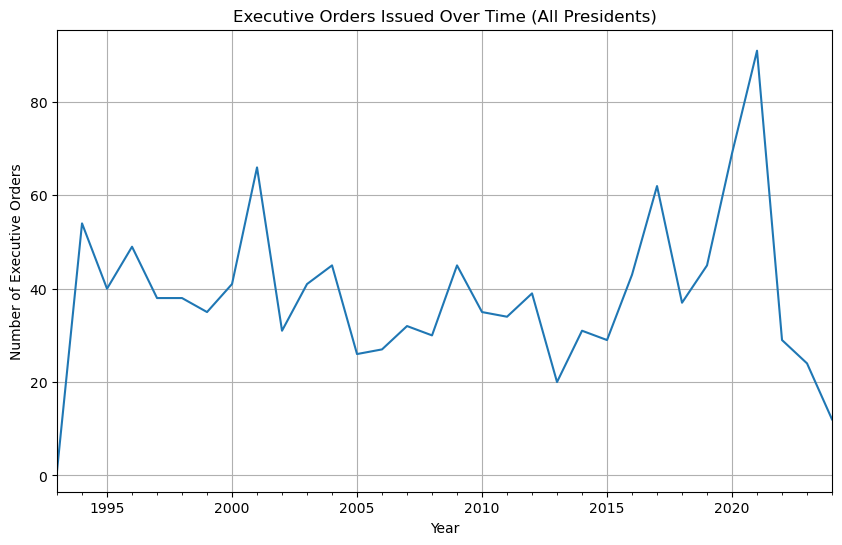

In [13]:
import matplotlib.pyplot as plt

# 1. Executive Orders Issued Over Time (All Presidents)
plt.figure(figsize=(10, 6))
data.set_index('signing_date').resample('Y').size().plot()
plt.title("Executive Orders Issued Over Time (All Presidents)")
plt.ylabel("Number of Executive Orders")
plt.xlabel("Year")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

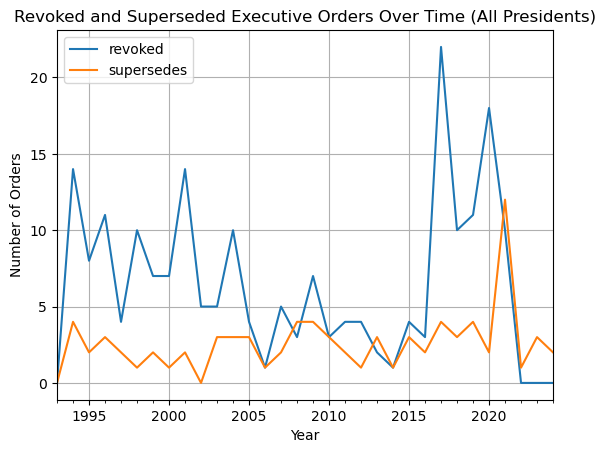

In [14]:
# 2. Revoked and Superseded Orders Over Time (All Presidents)
plt.figure(figsize=(10, 6))
data.set_index('signing_date').resample('Y')[['revoked', 'supersedes']].sum().plot()
plt.title("Revoked and Superseded Executive Orders Over Time (All Presidents)")
plt.ylabel("Number of Orders")
plt.xlabel("Year")
plt.grid(True)
plt.show()

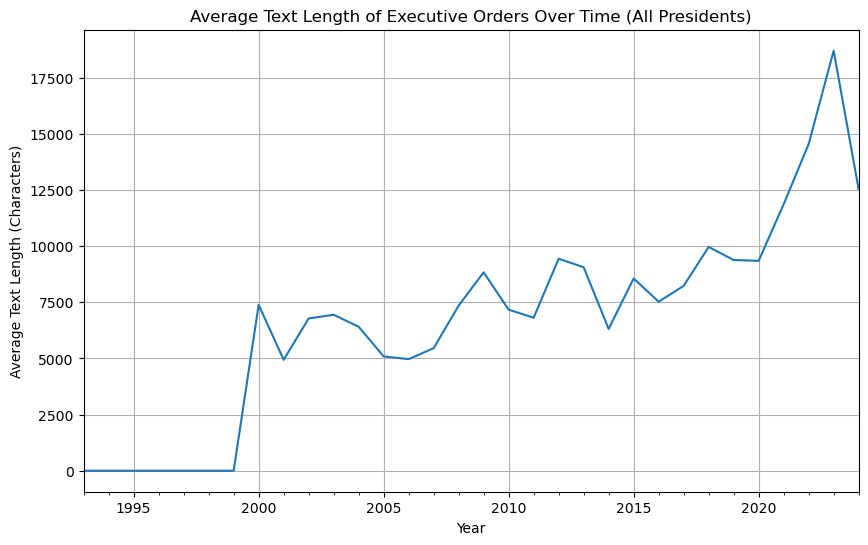

In [15]:
# 3. Text Length Trends Over Time (All Presidents)
plt.figure(figsize=(10, 6))
data.set_index('signing_date').resample('Y')['text_length'].mean().plot()
plt.title("Average Text Length of Executive Orders Over Time (All Presidents)")
plt.ylabel("Average Text Length (Characters)")
plt.xlabel("Year")
plt.grid(True)
plt.show()

### Biden and Trump Comparisons

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Filter data for Trump and Biden
trump_biden_data = data[data['president'].isin(['Donald Trump', 'Joseph R. Biden Jr.'])]

# Group by president and sum revoked and superseded orders
revoked_superseded = trump_biden_data.groupby('president')[['revoked', 'supersedes']].sum().reset_index()

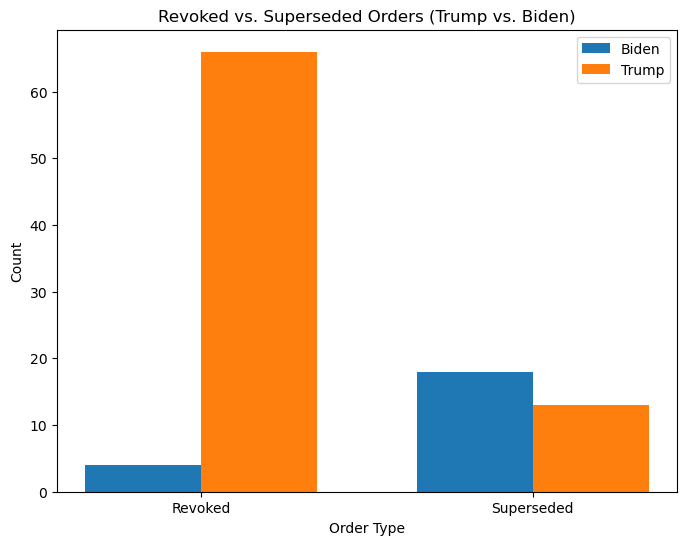

In [18]:
# Create a bar chart
labels = ['Revoked', 'Superseded']
biden_values = revoked_superseded[revoked_superseded['president'] == 'Joseph R. Biden Jr.'][['revoked', 'supersedes']].values[0]
trump_values = revoked_superseded[revoked_superseded['president'] == 'Donald Trump'][['revoked', 'supersedes']].values[0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, biden_values, width, label='Biden')
rects2 = ax.bar(x + width/2, trump_values, width, label='Trump')

# Add labels, title, and custom x-axis labels
ax.set_xlabel('Order Type')
ax.set_ylabel('Count')
ax.set_title('Revoked vs. Superseded Orders (Trump vs. Biden)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [19]:
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd

# Download the necessary NLTK resources
nltk.download('punkt')

# Function to calculate word count and lexical diversity
def calculate_text_complexity(text):
    words = word_tokenize(text)
    word_count = len(words)
    unique_word_count = len(set(words))
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    return word_count, lexical_diversity

# Apply the function to calculate word count and lexical diversity for Trump and Biden
trump_biden_data['word_count'], trump_biden_data['lexical_diversity'] = zip(*trump_biden_data['cleaned_text'].apply(calculate_text_complexity))

# Group by president to get average word count and lexical diversity
complexity_comparison = trump_biden_data.groupby('president').agg(
    avg_word_count=('word_count', 'mean'),
    avg_lexical_diversity=('lexical_diversity', 'mean')
).reset_index()

# Display the results
print(complexity_comparison)

[nltk_data] Downloading package punkt to /Users/ulrika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


             president  avg_word_count  avg_lexical_diversity
0         Donald Trump      831.681818               0.489124
1  Joseph R. Biden Jr.     1286.281690               0.444587


/var/folders/d9/q446vbvd4d13n4_kwld7sp340000gn/T/ipykernel_75322/2983746415.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_biden_data['word_count'], trump_biden_data['lexical_diversity'] = zip(*trump_biden_data['cleaned_text'].apply(calculate_text_complexity))
/var/folders/d9/q446vbvd4d13n4_kwld7sp340000gn/T/ipykernel_75322/2983746415.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_biden_data['word_count'], trump_biden_data['lexical_diversity'] = zip(*trump_biden_data['cleaned_text'].

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We'll perform topic modeling only on the text data of Trump and Biden to keep it focused.
# First, we ensure we have the cleaned text data.
trump_biden_texts = trump_biden_data['cleaned_text'].tolist()

# Step 1: Vectorize the text using a bag-of-words model
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(trump_biden_texts)

# Step 2: Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# Step 3: Extract the topics and their top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get the top words for each topic
no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
secretary pursuant property national usc act security including foreign emergency
Topic 2:
secretary federal policy health including community service american program public
Topic 3:
federal service director consistent enforcement general head policy regulation appropriate
Topic 4:
security secretary national appropriate information director ai including data day
Topic 5:
committee national council policy federal american advisory amended secretary member


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Assign topics to each executive order based on the LDA model
# Get the topic distribution for each document (executive order)
topic_distribution = lda_model.transform(X)

# Assign the most probable topic to each executive order
dominant_topics = np.argmax(topic_distribution, axis=1)

# Define the topic labels
topic_labels = {
    0: "National Security & Emergency Powers",
    1: "Health & Federal Programs",
    2: "Federal Services & Regulation",
    3: "Data Security & Information",
    4: "National Committees & Advisory Councils"
}

# Step 2: Add the topic labels to the dataframe
trump_biden_data['dominant_topic'] = dominant_topics
trump_biden_data['topic_label'] = trump_biden_data['dominant_topic'].map(topic_labels)

/var/folders/d9/q446vbvd4d13n4_kwld7sp340000gn/T/ipykernel_75322/4166612163.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_biden_data['dominant_topic'] = dominant_topics
/var/folders/d9/q446vbvd4d13n4_kwld7sp340000gn/T/ipykernel_75322/4166612163.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_biden_data['topic_label'] = trump_biden_data['dominant_topic'].map(topic_labels)


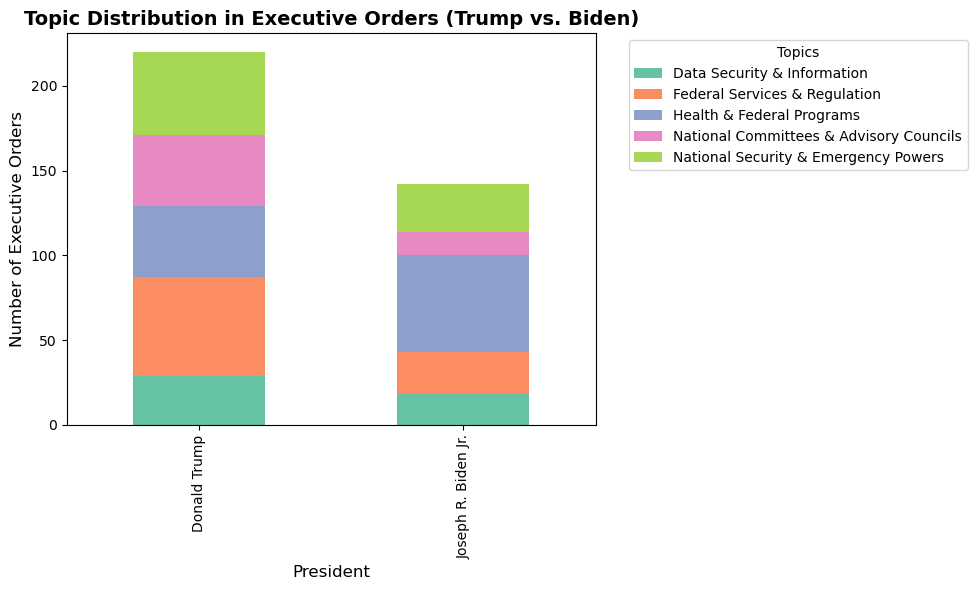

In [27]:
# Step 3: Create a bar chart comparing topic distribution between Trump and Biden

# Group by president and topic to count occurrences
topic_counts = trump_biden_data.groupby(['president', 'topic_label']).size().unstack().fillna(0)

# Step 4: Customize the color scheme with Seaborn's vibrant palette
color_palette = sns.color_palette("Set2", n_colors=5)  # Choose a pretty color palette with 5 colors

# Plot the results with custom colors
topic_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette)
plt.title("Topic Distribution in Executive Orders (Trump vs. Biden)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Executive Orders", fontsize=12)
plt.xlabel("President", fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/d9/q446vbvd4d13n4_kwld7sp340000gn/T/ipykernel_75322/2256985145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_biden_data['signing_date'] = pd.to_datetime(trump_biden_data['signing_date'])


<Figure size 1000x600 with 0 Axes>

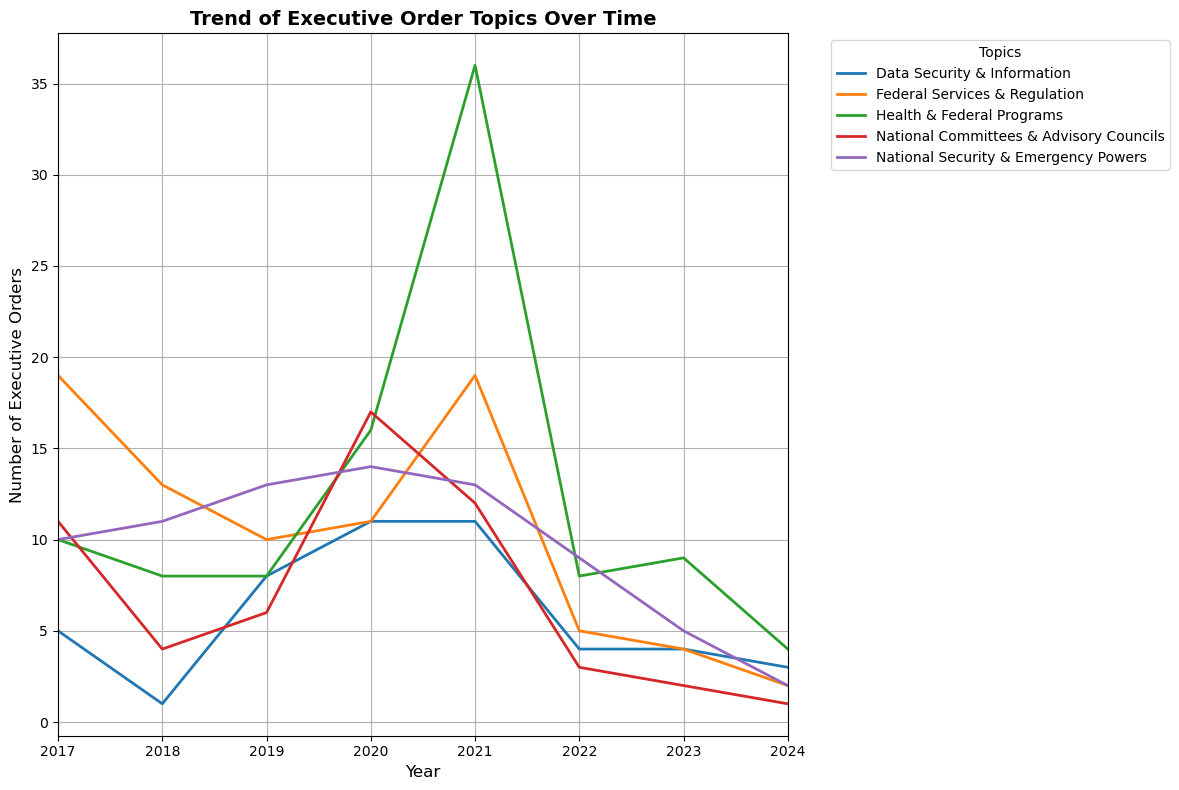

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Ensure the signing date is in datetime format
trump_biden_data['signing_date'] = pd.to_datetime(trump_biden_data['signing_date'])

# Step 2: Group by year and topic to get the count of executive orders for each topic over time
topic_trends = trump_biden_data.groupby([pd.Grouper(key='signing_date', freq='Y'), 'topic_label']).size().unstack().fillna(0)

# Step 3: Plot the time series trends for each topic
plt.figure(figsize=(10, 6))
topic_trends.plot(figsize=(12, 8), linewidth=2)

# Customize the plot
plt.title("Trend of Executive Order Topics Over Time", fontsize=14, fontweight='bold')
plt.ylabel("Number of Executive Orders", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()